In [21]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
import trace_analysis
import plots_analysis
import trace_statistics

# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# SVM
from sklearn import svm
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Data Preparation


Prepare the data to be used with kNN

In [22]:
plots = [("traces/normal", 'grid9_normal_2019-02-11_17:51:17_'),
         ("traces/normal", 'grid9_normal_2019-02-11_20:22:01_'),
         ("traces/normal", 'grid9_normal_2019-02-11_21:03:19_'),
         ("traces/normal", 'grid9_normal_2019-02-12_14:02:32_'),
         ("traces/normal", 'grid9_normal_2019-02-12_14:22:43_'),
         ("traces/1bh-3", 'grid9_1bh-3_2019-02-12_14:47:14_'),         
         ("traces/1bh-6", 'grid9_1bh-6_2019-02-11_20:48:08_'),
         ("traces/1bh-6", 'grid9_1bh-6_2019-02-11_21:03:19_'),
         ("traces/1bh-6", 'grid9_1bh-6_2019-02-12_13:35:47_'),
         ("traces/1bh-7", 'grid9_1bh-7_2019-02-12_14:02:32_'),
         ("traces/1bh-7", 'grid9_1bh-7_2019-02-12_14:22:43_'),         
         ("traces/1bh-3", 'grid9_1bh-3_2019-02-12_14:47:14_')
        ]

stats = None
win_25_stats = None
win_50_stats = None
win_100_stats = None

for row in plots:
    label = 'Normal'
    
    # Assign a label
    if row[0].find('gh') >= 0:
        label = 'Gray Hole'
    elif row[0].find('bh') >= 0:
        label = 'Black Hole'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label)
        win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, 50)
        win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, 100)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label)])
        win_25_stats = pd.concat([win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, 25)])
        win_50_stats = pd.concat([win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, 50)])
        win_100_stats = pd.concat([win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, 100)])
        
stats = stats.reset_index(drop=True)
win_25_stats = win_25_stats.reset_index(drop=True)
win_50_stats = win_50_stats.reset_index(drop=True)
win_100_stats = win_100_stats.reset_index(drop=True)
stats.head(5)

,node_id,count,mean,var,std,hop,min,max,loss,label
0,fd00::212:7405:5:505:,98,169.887755,4927.317168,70.194851,3,107.0,494.0,0.510,Normal
1,fd00::212:7404:4:404:,87,163.327586,31382.584812,177.151305,2,77.3,1205.0,0.565,Normal
2,fd00::212:7403:3:303:,92,60.042391,5431.264227,73.697111,1,28.3,707.0,0.540,Normal
3,fd00::212:7408:8:808:,90,233.155556,7211.548564,84.920837,4,169.0,929.0,0.550,Normal
4,fd00::212:7402:2:202:,99,145.127273,33352.392004,182.626373,2,69.4,1726.0,0.505,Normal


Select the set of features and labels that we use to fit the algorithm

In [23]:
# separate features from target values
features = win_100_stats.drop(columns=['node_id', 'label'])
target = win_100_stats['label'].values
print('Targets: ' + str(set(target)))

# split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)

Targets: {'Black Hole', 'Normal'}


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

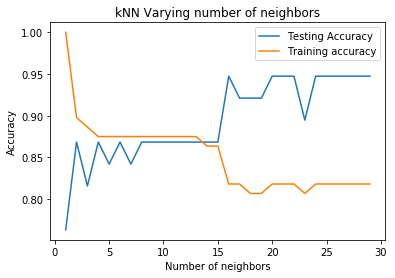

In [29]:
trace_analysis.knn_test_number_of_neighbors(X_train, X_test, y_train, y_test)

Let's build KNN classifier 

In [54]:
#Create KNN Classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn_clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn_clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("\n\n",classification_report(y_test,y_pred))


Accuracy: 0.8421052631578947


               precision    recall  f1-score   support

  Black Hole       0.97      0.86      0.91        36
      Normal       0.17      0.50      0.25         2

   micro avg       0.84      0.84      0.84        38
   macro avg       0.57      0.68      0.58        38
weighted avg       0.93      0.84      0.88        38



In [56]:
#train model with cv of 5
cv_scores = cross_val_score(knn_cv, features, target, cv = 5)

#print each cv score (accuracy) and average them
print('Mean Accuracy:{}'.format(np.mean(cv_scores)))

Mean Accuracy:0.85


# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [58]:
#Create a svm Classifier
svm_clf = svm.SVC(kernel='linear', random_state=9, gamma='scale') # Linear Kernel

#Train the model using the training sets
svm_clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = svm_clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("\n\n",classification_report(y_test,y_pred))

Accuracy: 0.9210526315789473


               precision    recall  f1-score   support

  Black Hole       0.97      0.94      0.96        36
      Normal       0.33      0.50      0.40         2

   micro avg       0.92      0.92      0.92        38
   macro avg       0.65      0.72      0.68        38
weighted avg       0.94      0.92      0.93        38



In [59]:
#train model with cv of 5
cv_scores = cross_val_score(svm_clf, features, target, cv = 5)

#print each cv score (accuracy) and average them
print('Mean Accuracy:{}'.format(np.mean(cv_scores)))

Mean Accuracy:0.8423076923076923


# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

No handles with labels found to put in legend.


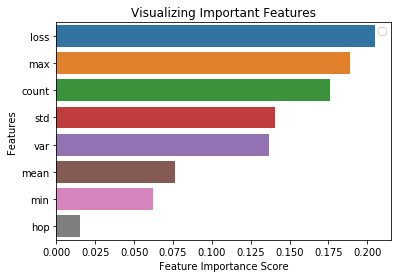

In [60]:
trace_analysis.random_forests_features_selection(X_train, X_test, y_train, y_test, features)

Select relevant features

In [61]:
# separate features from target values
features = stats.drop(columns=['node_id', 'label', 'hop','mean'])
target = stats['label'].values
print('Targets: ' + str(set(target)))

# split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)

Targets: {'Black Hole', 'Normal'}


Predicted values

In [62]:
#Create a Gaussian Classifier
rf_clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf_clf.fit(X_train,y_train)

y_pred = rf_clf.predict(X_test)


print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("\n\n",classification_report(y_test,y_pred))

Accuracy: 0.84


               precision    recall  f1-score   support

  Black Hole       0.95      0.86      0.90        22
      Normal       0.40      0.67      0.50         3

   micro avg       0.84      0.84      0.84        25
   macro avg       0.68      0.77      0.70        25
weighted avg       0.88      0.84      0.86        25



In [63]:
#train model with cv of 5
cv_scores = cross_val_score(rf_clf, features, target, cv = 5)

#print each cv score (accuracy) and average them
print('Mean Accuracy:{}'.format(np.mean(cv_scores)))

Mean Accuracy:0.8172549019607842
